In [4]:
import os
import sys

module_path = os.path.abspath(os.path.join('../ipsim'))
if module_path not in sys.path:
    sys.path.append(module_path)

import math
import numpy as np
import matplotlib.pyplot as plt

from ipsim import *

In [5]:
class TEOSimplified(ProcessNode):
    Rkcal = 1.987 # cal/(mol*K) constant for perfect gases in calories
    Rkj   = 8.31451 # J/(mol*K) constant for perfect gases in joulies
    rhoD  = 8.3 # kmol/m3 density of D
    T0    = 273.15  # K 0C in Kelvin
    k0    = 0.00117 # Constant for the isothermal operation
    def __init__(self, name, *
                 , Vr = 122 # m3 reactor volume
                 , Tr = 373 # K reactor temperature 
                 , N  = {"A":44.49999958429348
                        ,"B":13.53296996509594
                        ,"C":36.64788062995841
                        ,"D":110.0} #kmol - starting total molar holdup
                 ):
        super().__init__(name)
        self.Vr = Vr
        self.Tr = Tr
        self.N  = N
        self.P  = 0

        self.create_input("cAi1")
        self.create_input("cBi1")
        self.create_input("cCi1")
        self.create_input("svXi1")
        self.create_input("Fmi1")

        self.create_input("cAi2")
        self.create_input("svXi2")
        self.create_input("Fmi2")

        self.create_input("svXi3")
        self.create_input("cvi3")
        self.create_input("svXi4")
        self.create_input("cvi4")

        self.create_output("Fi1")
        self.create_output("Fi2")
        self.create_output("Fi3")
        self.create_output("Fi4")
        self.create_output("P")     

        self.create_output("vl")
        self.create_output("cAo")
        self.create_output("cBo")
        self.create_output("cCo")       
    
    def evaluate(self):
        i = self.inputs()
        cAi1  = i["cAi1"]()
        cBi1  = i["cBi1"]()
        cCi1  = i["cCi1"]()
        svXi1 = i["svXi1"]()
        Fmi1  = i["Fmi1"]()
        
        cAi2  = i["cAi2"]()
        svXi2 = i["svXi2"]()
        Fmi2  = i["Fmi2"]()
        
        svXi3 = i["svXi3"]()
        cvi3  = i["cvi3"]()
        svXi4 = i["svXi4"]()
        cvi4  = i["cvi4"]()

        dt = self._model.dt()

        vd = self.N["D"]/TEOSimplified.rhoD
        vv = self.Vr - vd

        pa = self.N["A"]*TEOSimplified.Rkj*self.Tr/vv
        pb = self.N["B"]*TEOSimplified.Rkj*self.Tr/vv
        pc = self.N["C"]*TEOSimplified.Rkj*self.Tr/vv
        P = pa+pb+pc

        Fi1 = svXi1*Fmi1
        Fi2 = svXi2*Fmi2
        Fi3 = 100*svXi3*cvi3*math.sqrt(P-100) if P-100 > 0 else 0
        Fi4 = 100*svXi4*cvi4*math.sqrt(P-100) if P-100 > 0 else 0

        R = TEOSimplified.k0*math.pow(pa,1.2)*math.pow(pc,0.4) if ((pa > 0) and (pc > 0)) else 0
        dNa = (cAi1*Fi1 + cAi2*Fi2 - Fi3*pa/P - R)*dt
        dNc = (cCi1*Fi1 - Fi3*pc/P - R)*dt
        dNb = (cBi1*svXi1*Fmi1 - Fi3*pb/P)*dt
        dNd = (R - Fi4)*dt
        
        self.N["A"] = self.N["A"] + dNa  
        self.N["B"] = self.N["B"] + dNb
        self.N["C"] = self.N["C"] + dNc
        self.N["D"] = self.N["D"] + dNd

        if self.N["A"] < 0:
            self.N["A"] = 0

        if self.N["B"] < 0:
            self.N["B"] = 0

        if self.N["C"] < 0:
            self.N["C"] = 0

        if self.N["D"] < 0:
            self.N["D"] = 0
            
        self.set_result("Fi1", Fi1)
        self.set_result("Fi2", Fi2)
        self.set_result("Fi3", Fi3)
        self.set_result("Fi4", Fi4)
        self.set_result("P", P)     

        self.set_result("vl" , vd)
        self.set_result("cAo", pa/P)
        self.set_result("cBo", pb/P)
        self.set_result("cCo", pc/P)


In [6]:
def prepare_model():    
    processModel = ProcessModel("test",dt=1.0/3600.0) #time dimention for all variables specified in hours here dt is 1 sec
    processModel.add_node(ProcessInputNode("Stream1",{ "cA":0.485
                                                     , "cB":0.005
                                                     , "cC":0.51
                                                     , "svX":0.6095327313484253
                                                     , "Fmax":330.46})) #Fmax is a constant but to not to specifi distinct input node class
                                                                        #that calculate F depending on svX and Fmax we pass it as parameter
                                                                        #also thats true for other valves and Cv constants
    processModel.add_node(ProcessInputNode("Stream2", {"cA":1, "svX":0.2502232231706676 , "Fmax": 22.46}))
    processModel.add_node(ProcessInputNode("Stream3", {"svX":0.392577701760644, "cv":0.00352}))
    processModel.add_node(ProcessInputNode("Stream4", {"svX":0.4703024823457651 , "cv":0.0417}))

    processModel.add_node(TEOSimplified("TEPS"))
    processModel.bond_nodes("TEPS","cAi1" , "Stream1", "cA")
    processModel.bond_nodes("TEPS","cBi1" , "Stream1", "cB")
    processModel.bond_nodes("TEPS","cCi1" , "Stream1", "cC")
    processModel.bond_nodes("TEPS","svXi1", "Stream1", "svX")
    processModel.bond_nodes("TEPS","Fmi1" , "Stream1", "Fmax")

    processModel.bond_nodes("TEPS","cAi2" , "Stream2", "cA")
    processModel.bond_nodes("TEPS","svXi2", "Stream2", "svX")
    processModel.bond_nodes("TEPS","Fmi2" , "Stream2", "Fmax")

    processModel.bond_nodes("TEPS","svXi3", "Stream3", "svX")
    processModel.bond_nodes("TEPS","cvi3" , "Stream3", "cv")
    processModel.bond_nodes("TEPS","svXi4", "Stream4", "svX")
    processModel.bond_nodes("TEPS","cvi4" , "Stream4", "cv")

    return processModel

In [7]:
def run_model(process_model, iterations=60*5): #5 minutes
    parametersMetadata = (
          {"parameter":"P", "range":(2000,3000)}
        , {"parameter":"vl", "range":(0,100)}
        , {"parameter":"Fi3", "range":(0,100)}
        , {"parameter":"cAo", "range":(0,1)}
        , {"parameter":"Fi1", "range":(0,300)}
        , {"parameter":"Fi2", "range":(0,30)}
        , {"parameter":"Fi4", "range":(0,200)}
        , {"parameter":"cBo", "range":(0,1)}
        , {"parameter":"cCo", "range":(0,1)}
    )
    x = np.empty((iterations,len(parametersMetadata)))
    for _ in range(iterations):
        state = process_model.next_state(("TEPS",))
        data =  []
        for metadata in parametersMetadata:
             data.append(state['TEPS'][metadata["parameter"]])
        x[_] =  data
    return x, parametersMetadata

In [12]:
def show_data(x, metadata, title = "", *, cols=3):
    fig = plt.figure(figsize=(12,12),)
    fig.suptitle(title)
    paramsCount = len(metadata)
    rows = int(paramsCount / cols) + (1 if paramsCount % cols > 0 else 0 )
    
    for r in range(0, rows):
        for c in range(0,cols):
            index = r*cols + c
            if index < paramsCount:
                plt.subplot(rows, cols, index+1)
                if metadata[index]["range"] is not None:
                    plt.ylim(metadata[index]["range"][0], metadata[index]["range"][1])
                plt.plot(x[:,index])
                plt.title(metadata[index]["parameter"])
    plt.show()

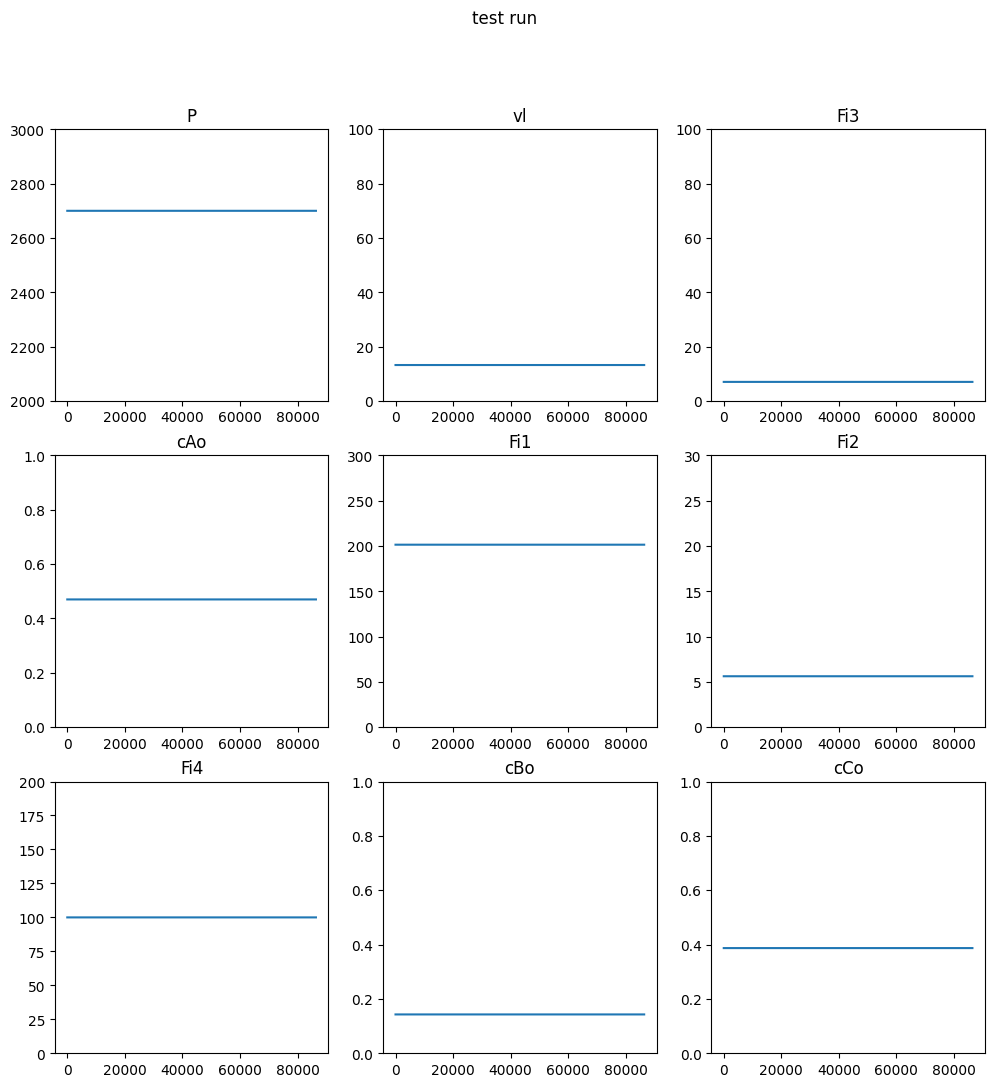

In [13]:
process_model = prepare_model()
data, metadata = run_model(process_model, 60*60*24)
show_data(data, metadata,"test run", cols=3)